In [4]:
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
import json
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer

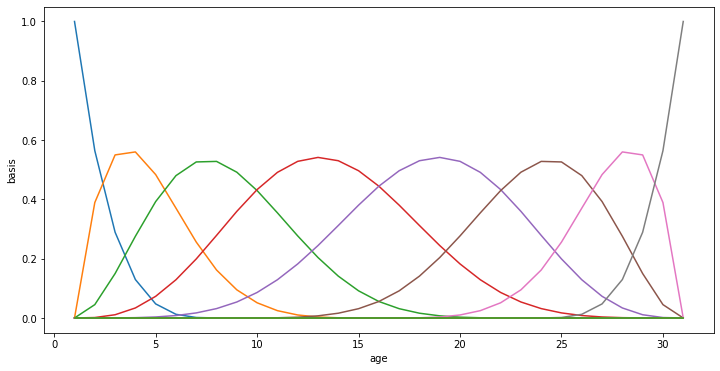

In [5]:
# knot 수에 따라 Bspline 파일 변

degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [6]:
transformer = PowerTransformer()
y_data_raw = pd.read_csv("../data/y_count_original.csv")
y_data_raw.drop(columns="age", inplace=True)
transformer.fit_transform(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1))

y_data = pd.read_csv(os.path.realpath("../data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("../data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("../data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("../data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]


y_data.shape, age_data.shape, ship_data.shape, engine_data.shape, ship_engine_mapping_data.shape

((653, 1), (653, 1), (653, 1), (653, 1), (99, 1))

In [7]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = int(y_data.shape[0])
engine_count, ship_count, max_age, data_count

(5, 99, 31, 653)

In [8]:
model_file = os.path.join('./models','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=model_file) #compile_model(layer3_path)

INFO:cmdstanpy:compiling stan program, exe file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/stancode/layer3_nc_diffsd_parammubar
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/stancode/layer3_nc_diffsd_parammubar


In [9]:
data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : max_age,  # length of time of data(31)
    "S" : ship_count, #failure_df.shape[1],  # number of ships(99)
    "E" : engine_count,  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [10]:
layer3_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


In [11]:
layer3_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpzu7eime9/layer3_nc_diffsd_parammubar-202008201852-1-8x8t7_l7.csv, /tmp/tmpzu7eime9/layer3_nc_diffsd_parammubar-202008201852-2-s7du7jrv.csv, /tmp/tmpzu7eime9/layer3_nc_diffsd_parammubar-202008201852-3-cgusbpb6.csv, /tmp/tmpzu7eime9/layer3_nc_diffsd_parammubar-202008201852-4-yfdktnyd.csv

Checking sampler transitions treedepth.
3997 of 4000 (1e+02%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
3 of 4000 (0.075%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI s

"Processing csv files: /tmp/tmpzu7eime9/layer3_nc_diffsd_parammubar-202008201852-1-8x8t7_l7.csv, /tmp/tmpzu7eime9/layer3_nc_diffsd_parammubar-202008201852-2-s7du7jrv.csv, /tmp/tmpzu7eime9/layer3_nc_diffsd_parammubar-202008201852-3-cgusbpb6.csv, /tmp/tmpzu7eime9/layer3_nc_diffsd_parammubar-202008201852-4-yfdktnyd.csv\n\nChecking sampler transitions treedepth.\n3997 of 4000 (1e+02%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\n3 of 4000 (0.075%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI s

In [12]:
layer3_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-251.328000,0.126607,4.556220,-259.257000,-251.029000,-244.388000,1295.060,2.10184,1.001290
mu_a_bar,-0.010079,0.026748,0.998754,-1.624780,-0.005975,1.655940,1394.210,2.26276,1.000790
mu_w_bar[1],-1.532290,0.018692,0.493121,-2.351230,-1.527500,-0.731165,695.954,1.12951,1.004790
mu_w_bar[2],0.365634,0.020129,0.530327,-0.519797,0.364621,1.221200,694.109,1.12652,1.003170
mu_w_bar[3],-0.443938,0.022389,0.617193,-1.454760,-0.451135,0.567290,759.934,1.23335,1.001660
...,...,...,...,...,...,...,...,...,...
y_new_pred[649],0.981379,0.014442,0.890471,-0.478951,0.989825,2.448770,3801.590,6.16986,0.999624
y_new_pred[650],1.007160,0.014908,0.896677,-0.434941,0.990291,2.475260,3617.610,5.87127,1.000840
y_new_pred[651],0.988429,0.014405,0.902572,-0.514296,0.964921,2.495300,3925.760,6.37138,0.999958


In [45]:
yhat = np.mean(layer3_fit.get_drawset(params=["y_new_pred"]), axis=0).values
yhat.shape

(653,)

In [46]:
mean_squared_error(yhat, y_data["y"].values)

0.7927148493668374

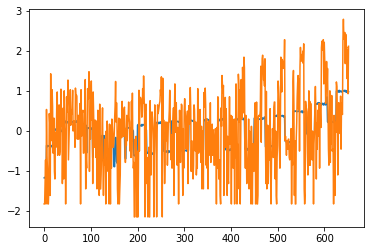

In [49]:
ax = plt.gca()
ax.plot(np.arange(0, yhat.shape[0]), yhat)
ax.plot(np.arange(0, yhat.shape[0]), y_data["y"].values)

In [15]:
lambda_ = np.array([0.21649144])
mean_ = np.array([4.96401329])
var_ = np.array([5.32670014])
scale_ = np.array([2.3079645])
n_samples_seen_ = 653
yhat = transformer.inverse_transform(yhat.reshape(-1, 1)).flatten()

In [31]:
yhat

array([ 5.26680642,  5.39757864,  5.34745077,  5.26413928,  5.00417019,
       17.97463706, 18.10456612, 17.32393166, 17.93482475, 17.74651254,
       17.86895342, 17.49217015, 17.4242002 , 17.50669637, 18.09707831,
       17.42383235, 18.02255257, 17.77305348, 16.61695293, 16.57001782,
       17.07637291, 29.4264646 , 28.97576872, 28.76076292, 28.68258998,
       29.77207453, 29.63527582, 29.56013246, 29.6539819 , 29.53907279,
       29.30630841, 28.9838983 , 28.74895068, 30.06698088, 28.96005193,
       29.28011607, 27.66945433, 27.57151481, 27.92518369, 28.60856201,
       35.8494708 , 35.76922114, 35.13962298, 35.54615457, 34.55432954,
       37.06020123, 36.11013302, 35.76750045, 35.80710622, 36.35213601,
       35.26381857, 35.2179244 , 36.66260338, 35.18596058, 35.93916302,
       34.12368864, 35.07936618, 34.40632007, 36.75853583, 36.10175311,
       35.83395427, 36.43967969, 36.25549752, 35.99877576, 36.24025376,
       35.88008374, 36.33340414, 36.06442843, 36.76801425, 35.70

In [32]:
smape(yhat, transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten())

0.735765831992664

In [33]:
mean_squared_error(yhat, transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten())

1692.090061819637

In [35]:
res = transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten() - yhat
np.std(res)

39.342905562020356

In [36]:
np.mean(res)

12.0094064698296

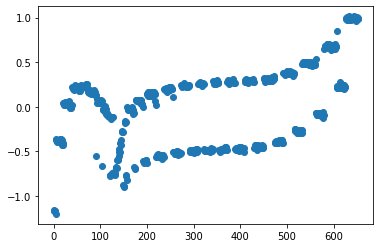

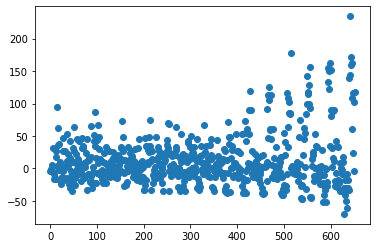

In [37]:
ax = plt.gca()
ax.scatter(np.arange(0, yhat.shape[0]), res, label="y - yhat")

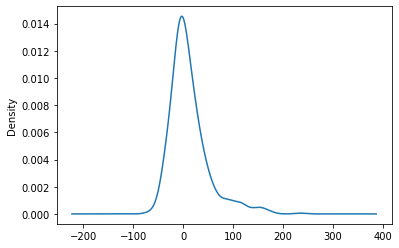

In [38]:
pd.Series(res).plot.kde()